In [1]:
import os
from os import path
import json
import numpy as np
import pandas as pd

In [63]:
path_results = './results/'

acceptance_policy = 'acceptall'
path_acceptance = path.join(path_results, acceptance_policy)

# placement_policies = list(os.listdir(path_acceptance))
placement_policies = ['default', 'greedy', 'best', 'gavel', 'sgavel']
scheduling_policies = ['fifo', 'las']

range_str = '0_500'
test_prefix = f'test_{range_str}_load_'
job_loads = [10, 50]

percentiles = [ 5, 50, 95, 99 ]
# Each test is a combination of placer, scheduler, and load.
# For each of these combinations, we want to display JCT: mean, common percentiles (5%, 50%, 95%), number of swaps, cluster utilization

# This is difficult to show compactly and we might need to split this into 4 tables, perhaps one for each combination of scheduler and load

test_configurations = []
test_load = []
test_placement = []
test_scheduler = []
test_means = []
test_percentiles = {perc: [] for perc in percentiles}
test_swaps = []
test_utilization = {}
test_swaps_disaggregated = {}
for load in job_loads:
    for scheduler_name in scheduling_policies:
        for placement_name in placement_policies:        

            # Collect configuration parameters
            configuration_tuple = (placement_name, scheduler_name, load)
            # test_configurations.append(configuration_tuple)
            test_load.append(load)
            test_placement.append(placement_name)
            test_scheduler.append(scheduler_name)
            
            # Collect JCT summary statistics
            path_to_test_dir = path.join(path_acceptance, placement_name, scheduler_name)
            test_metric_str = 'job_stats'
            filename_test = f'{test_prefix}{load}_{test_metric_str}.json'
            path_test = path.join(path_to_test_dir, filename_test)
            # print(path_test)

            with open(path_test, "r") as fin:
                data_job = json.load(fin)
            # print(data_job)
            job_durations = {j: v[1] - v[0] for j,v in data_job.items()}
            # print(job_durations.values())
            job_durations_list = list(job_durations.values())
            test_mean = np.mean(job_durations_list)
            # test_mean_resized = np.round(int(test_mean) / 1000, decimals=1)
            # print(test_mean)
            # test_means.append(test_mean_resized)
            test_means.append(test_mean)

            for p in percentiles:
                jct_perc = np.percentile(job_durations_list, p)
                # print(f'{p} percentile JCT: {jct_perc}')
                test_percentiles[p].append(jct_perc)

            # Collect number of preemptions ("swaps")
            test_metric_str = 'run_time_stats'
            filename_test = f'{test_prefix}{load}_{test_metric_str}.json'
            path_test = path.join(path_to_test_dir, filename_test)

            with open(path_test, "r") as fin:
                data_job = json.load(fin)
            swaps_disaggregated = [v['swap_count'] for v in data_job.values()]
            test_swaps_disaggregated[configuration_tuple] = swaps_disaggregated
            num_preemptions = np.sum(swaps_disaggregated)
            test_swaps.append(num_preemptions)

            # Collect cluster utilization
            test_metric_str = 'cluster_stats'
            filename_test = f'{test_prefix}{load}_{test_metric_str}.json'
            path_test = path.join(path_to_test_dir, filename_test)

            with open(path_test, "r") as fin:
                data_job = json.load(fin)
            utilization = np.array(data_job['utilization'])
            test_utilization[configuration_tuple] = utilization
            # num_preemptions = np.sum([v['swap_count'] for v in data_job.values()])
            # test_swaps.append(num_preemptions)

# print(test_configurations)
# print(test_means)
# print(test_percentiles)

# '5th percentile': test_percentiles[5]
# metrics_JCT = pd.DataFrame({'Test Configuration':test_configurations , 'Mean': test_means, 'Median': test_percentiles[50], '95th Percentile': test_percentiles[95], '99th Percentile': test_percentiles[99], '# Swaps': test_swaps})
metrics_JCT = pd.DataFrame({'Load': test_load, 'Scheduling Policy': test_scheduler, 'Placement Policy': test_placement, 'Mean': test_means, 'Median': test_percentiles[50], '95th Percentile': test_percentiles[95], '99th Percentile': test_percentiles[99], '# Swaps': test_swaps})

# sample_row = {'Test Configuration': 'Hamburger', 'Mean': 33, '5th percentile': 55, 'Median': 77, '95th Percentile': 99}
#
# metrics_JCT._append(sample_row, ignore_index=True)

# TODO mark default,fifo entries as possibly being incorrect. Do not incldue in figures

cols = metrics_JCT.columns[3:]

metrics_JCT[cols] /= 1000
metrics_JCT = metrics_JCT.round(1)

display(metrics_JCT)

,Load,Scheduling Policy,Placement Policy,Mean,Median,95th Percentile,99th Percentile,# Swaps
0,10,fifo,default,164.2,131.5,312.7,1005.0,0.0
1,10,fifo,greedy,21.4,4.9,108.3,187.2,0.0
2,10,fifo,best,17.5,5.0,87.9,148.1,3.8
3,10,fifo,gavel,18.8,5.0,94.5,165.2,2.9
4,10,fifo,sgavel,18.9,4.9,95.7,163.7,3.5
5,10,las,default,46.4,7.8,188.8,825.2,0.0
6,10,las,greedy,21.4,4.9,108.3,187.2,0.0
7,10,las,best,17.5,4.8,87.9,148.1,3.4
8,10,las,gavel,18.9,5.0,92.6,173.2,2.8
9,10,las,sgavel,18.9,4.9,94.5,164.3,3.5


heatmap_Mean_fifo.png
heatmap_Mean_las.png


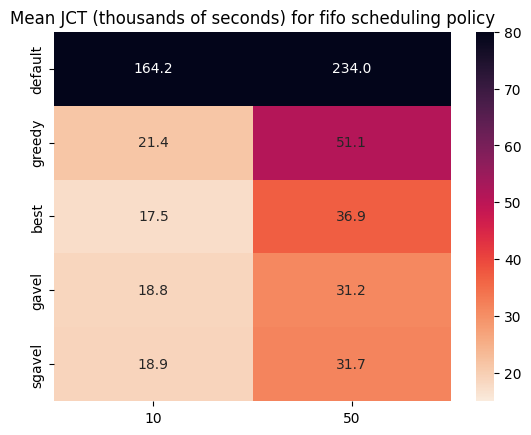

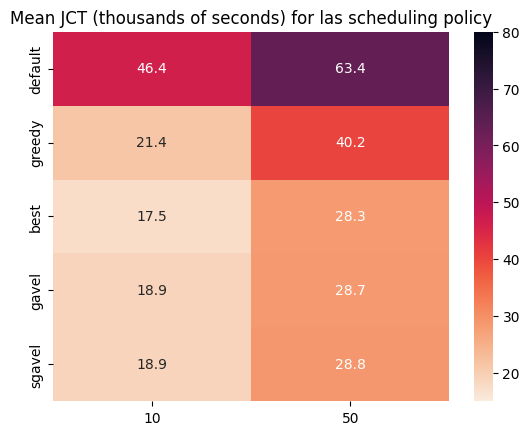

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns 

for s in scheduling_policies:
    m = 'Mean'
    plt.figure()
    df = metrics_JCT.loc[metrics_JCT["Scheduling Policy"] == s]
    df2 = pd.DataFrame(np.reshape(df[m].values, (2, 5)).T, columns=["10", "50"], index=metrics_JCT["Placement Policy"].values[:5])
    # sns.heatmap(df2, annot=True, fmt=".1f", cmap="crest")
    ax = sns.heatmap(df2, annot=True, fmt=".1f", cmap="rocket_r")
    ax.collections[0].set_clim((15,80))
    plt.title(f'{m} JCT (thousands of seconds) for {s} scheduling policy')
    # plt.plot()
    fig_file_title = f'heatmap_{m}_{s}.png'
    print(fig_file_title)
    path_fig = path.join('plots_allredudes', fig_file_title)
    plt.savefig(path_fig)

GPU_utilization.png


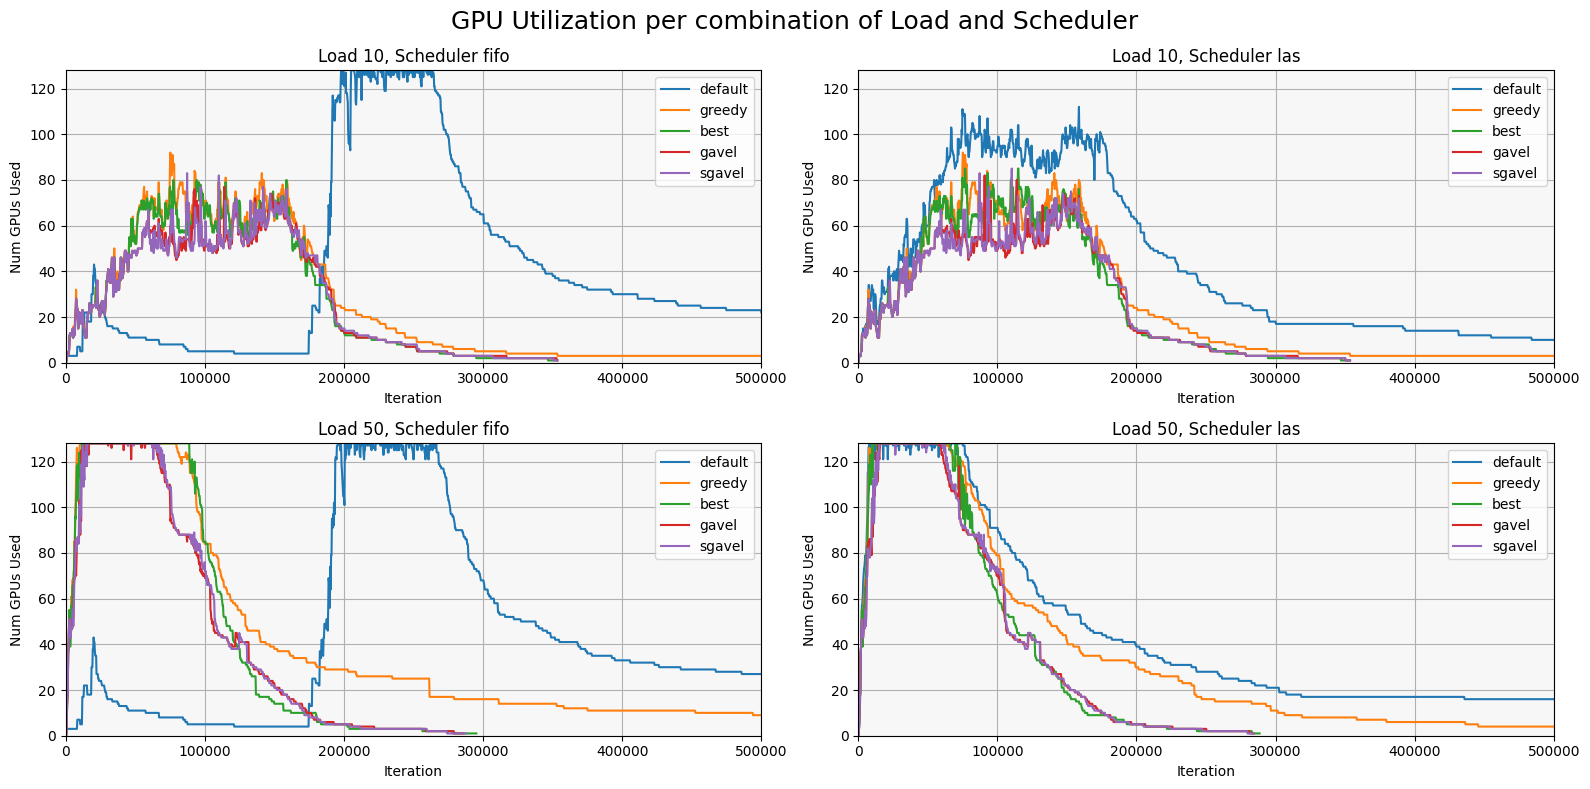

In [105]:
fig, axs = plt.subplots(2, 2)
for u, v in test_utilization.items():
    axs[i,j].set_xlabel("Iteration")
    axs[i,j].set_ylabel("Num GPUs Used")
    placement, scheduler, load = u
    i = job_loads.index(load)
    j = scheduling_policies.index(scheduler)

    axs[i,j].set_title(f"Load {load}, Scheduler {scheduler}")
    
    axs[i,j].set_xlim(0, 0.5e6)
    axs[i,j].set_ylim(0, 128)
    axs[i,j].plot(v[:,0], v[:,1], label=placement)
    axs[i,j].legend()
    axs[i,j].grid()
    axs[i,j].set_facecolor('#f7f7f7')

fig.set_figwidth(16)
fig.set_figheight(8)
plt.suptitle('GPU Utilization per combination of Load and Scheduler', fontsize='18')
plt.tight_layout()

fig_file_title = f'GPU_utilization.png'
print(fig_file_title)
path_fig = path.join('plots_allredudes', fig_file_title)
plt.savefig(path_fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

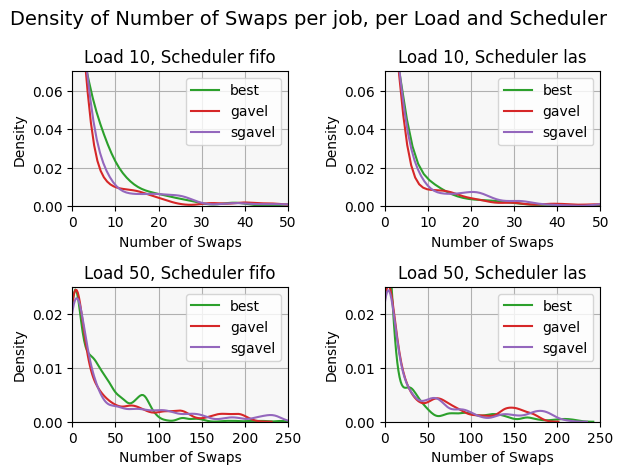

In [101]:
fig, axs = plt.subplots(2, 2)
for u, v in test_swaps_disaggregated.items():
    axs[i,j].set_xlabel("Number of Swaps")
    axs[i,j].set_ylabel("Density")
    # plt.ylabel("Number of Swaps")
    placement, scheduler, load = u
    i = job_loads.index(load)
    j = scheduling_policies.index(scheduler)

    axs[i,j].set_title(f"Load {load}, Scheduler {scheduler}")
    
    if load == 10:
        axs[i,j].set_xlim(0, 50)
        axs[i,j].set_ylim(0, 0.07)
    else:
        axs[i,j].set_xlim(0, 250)
        axs[i,j].set_ylim(0, 0.025)

    # 
    sns.kdeplot(v, ax=axs[i,j], label=placement, warn_singular=False, bw_adjust=0.5)
    # bw_adjust controls smoothness of density curve. Higher=more smooth
    # axs[i,j].plot(v[:,0], v[:,1], label=placement)
    axs[i,j].legend()
    axs[i,j].grid()
    axs[i,j].set_facecolor('#f7f7f7')

plt.suptitle('Density of Number of Swaps per job, per Load and Scheduler', fontsize='14')
plt.tight_layout()

fig_file_title = f'density_of_swaps.png'
print(fig_file_title)
path_fig = path.join('plots_allredudes', fig_file_title)
plt.savefig(path_fig)